In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional,BatchNormalization, Activation, Embedding, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
import datetime
import time
import random
import matplotlib.pyplot as plt

In [2]:
MIN_CONTENTS_ON_USER = 250
MAX_DAYS = 7
MAX_SEQUENCE = 6
DATA_DIR = "data"
recommandation_df = pd.read_csv('{}/normalizedata.csv'.format(DATA_DIR)).sort_values(by=['time'])

In [3]:
def convertToTimemillis(date):
    try:
        d = datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").strftime('%s.%f')
        return int(float(d)*1000)
    except:
        pass
    return 0

def getSortedClass():
    levels = []
    levels.append([0, MIN_CONTENTS_ON_USER+1])
    contentLevels = recommandation_df['Content'].values
    for contentLevel in contentLevels:
        add = True
        indexLevel = 0
        for key, level in levels:
            if contentLevel == key:
                add = False
                levels[indexLevel] = ([key, level+1])
                break
            else:
                indexLevel+=1
        if add:
            levels.append([contentLevel, 1])

    classContents = []
    for key, level in levels:
        if level > MIN_CONTENTS_ON_USER:
            classContents.append(key)
            
    sortedClassContents = sorted(classContents)
    print(sortedClassContents)
    return sortedClassContents

def saveClassesToFile(classes):
    label_file = open("label.txt", "w")
    np.savetxt(label_file, classes)
    label_file.close()


def checkingTimeDifferent(nowDate, beforeDate):
    now = convertToTimemillis(nowDate)
    before = convertToTimemillis(beforeDate)
    return (now - before) >  (MAX_DAYS * 86400000)


def buildFeature(paramsContents, sortedClassContents):
    feature = []
    for ignore in range(MAX_SEQUENCE-len(paramsContents)):
        feature.append(0)
    for content in paramsContents:
        feature.append(sortedClassContents.index(content))
        
    return feature

def checkConsists(item, contents):
    next = False
    for content in contents:
        if(content == item):
            next = True
    return next


def findTopDataSet(dataSet):
    unique = []
    for x, y in dataSet:
        new = True
        i = 0
        for u, l in unique:
            if u == x:
                new = False
                l.append(y)
                unique[i] = [u, l]
            i+=1
        if new:
            unique.append([x,[y]])
    result = []
    for x, y in unique:
        scores = []
        for i in y:
            new = True
            numbersIndex = 0
            for z, score in scores:
                if i == z:
                    new = False
                    scores[numbersIndex] = [i, score+1]
                numbersIndex += 1
            scores.append([i, 0])
        maxY = 0
        topY =  scores[0][0]
        for n, score in scores:
            if(score > maxY):
                maxY = score
                topY = n
        result.append([x,topY])
    return result

In [4]:
sortedClassContents = getSortedClass()
saveClassesToFile(sortedClassContents)
lenSortedClassContents = len(sortedClassContents)
print(lenSortedClassContents)

[0, 1, 15, 23, 39, 69, 79, 162, 169, 202, 205, 213, 252, 255, 306, 308, 312, 322, 369, 371, 379, 434, 448, 455, 478, 479, 480, 481, 492, 507, 513, 535, 548, 623, 626, 640, 644, 657, 682, 683, 697, 700, 752, 772, 776, 777, 781, 824, 832, 839, 883, 913, 936, 960, 964, 977, 989, 993, 1006, 1020, 1026, 1115, 1137, 1185, 1187, 1193, 1239, 1242, 1256, 1269, 1304, 1310, 1397, 1415, 1420, 1428, 1429, 1433, 1436, 1437, 1490, 1498, 1506, 1512, 1521, 1534, 1554, 1559, 1567, 1578, 1579, 1589, 1591, 1599, 1602, 1606, 1607, 1609, 1619, 1620, 1624, 1641, 1652, 1659, 1677, 1700, 1716, 1719, 1756, 1758, 1774, 1777, 1781, 1788, 1790, 1791, 1795, 1798, 1806, 1807, 1813, 1819, 1823, 1826, 1830, 1833, 1834, 1836, 1838, 1839, 1840, 1845, 1847, 1853, 1855, 1862, 1863, 1872, 1873, 1876, 1877, 1879, 1885, 1896, 1910, 1912, 1913, 1927, 1928, 1935, 1936]
151


In [5]:
visitors_df = recommandation_df['visitor'].drop_duplicates()
maxItem = recommandation_df['Content'].max()
training_data = []
for index, item in visitors_df.iteritems():
    video = recommandation_df[recommandation_df['visitor'] == item]
    if video.size > 1:
        tempContents = []
        indexContent = 0
        for index, item in video['Content'].iteritems():
            if(item not in sortedClassContents):
                continue
            if len(tempContents) > MAX_SEQUENCE: 
                tempContents = tempContents[1:]
                continue
            if(checkConsists(item, tempContents)):
                continue
            if len(tempContents) > 0:
                nowDate = video['time'].iloc[indexContent]
                beforeDate = video['time'].iloc[indexContent-1]
                
                if checkingTimeDifferent(nowDate, beforeDate):
                    tempContents = []
                else:
                    feature = buildFeature(tempContents, sortedClassContents)
                    label = sortedClassContents.index(item)
                    training_data.append([[feature], label])
            tempContents.append(item)
            indexContent += 1

training_data = findTopDataSet(training_data)
print("training size: ", len(training_data))

random.shuffle(training_data)

training size:  8940


In [6]:
features = []
labels = []
for feature, label in training_data:
    features.append(feature)
    labels.append(label)

In [53]:
X = np.array(features)
Y = np.array(labels).astype(np.float32)
print(X)
print(X.shape)


[[[  0 134  92   5  14 122]]

 [[  0   0  72 147 145 143]]

 [[  0 102 127 122 114  27]]

 ...

 [[  0   0   0   0  72  93]]

 [[  0   0   0  27  73  21]]

 [[  0   0   0 141  75  97]]]
(8940, 1, 6)


In [ ]:
# for lstm with embedding
X = np.squeeze(X, axis=1)
model = Sequential()
model.add(Embedding(lenSortedClassContents, 128, input_length=MAX_SEQUENCE))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(lenSortedClassContents, activation='softmax'))
# adam = Adam(lr=0.01)
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# for pure lstm

X = np.squeeze(X, axis=1)
X = X.reshape(X.shape[0], X.shape[1], 1)
print (X)
print (X.shape)
model = Sequential()
model.add(LSTM(256, input_shape=X.shape[1:], return_sequences=True) )
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(Dense(lenSortedClassContents))
model.add(Activation("softmax"))
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [54]:
# for cnn
# not working since the data need more normalize
X = np.squeeze(X, axis=1)
X = X.reshape(X.shape[0], X.shape[1], 1)
model = Sequential()
model.add(Conv1D(128, 2, activation="relu", input_shape=X.shape[1:]))
model.add(Conv1D(128, 2, activation="relu"))
model.add(Conv1D(128, 2, activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(lenSortedClassContents, activation='softmax'))
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [55]:
name = "testing-1"
tensorboard = TensorBoard(log_dir='logs/{}'.format(name))
history = model.fit(X, Y, epochs=256, batch_size=64, verbose=1, callbacks=[tensorboard])

Epoch 1/256
140/140 [==============================] - 0s 2ms/step - loss: 4.9090 - accuracy: 0.0192
Epoch 2/256
140/140 [==============================] - 0s 2ms/step - loss: 4.8524 - accuracy: 0.0202
Epoch 3/256
140/140 [==============================] - 0s 2ms/step - loss: 4.8414 - accuracy: 0.0201
Epoch 4/256
140/140 [==============================] - 0s 2ms/step - loss: 4.8196 - accuracy: 0.0219
Epoch 5/256
140/140 [==============================] - 0s 2ms/step - loss: 4.8023 - accuracy: 0.0234
Epoch 6/256
140/140 [==============================] - 0s 2ms/step - loss: 4.7785 - accuracy: 0.0247
Epoch 7/256
140/140 [==============================] - 0s 2ms/step - loss: 4.7643 - accuracy: 0.0249
Epoch 8/256
140/140 [==============================] - 0s 2ms/step - loss: 4.7395 - accuracy: 0.0282
Epoch 9/256
140/140 [==============================] - 0s 2ms/step - loss: 4.7195 - accuracy: 0.0280
Epoch 10/256
140/140 [==============================] - 0s 2ms/step - loss: 4.6989 - accura

140/140 [==============================] - 0s 3ms/step - loss: 2.5901 - accuracy: 0.3549
Epoch 79/256
140/140 [==============================] - 0s 3ms/step - loss: 2.6150 - accuracy: 0.3474
Epoch 80/256
140/140 [==============================] - 0s 3ms/step - loss: 2.5695 - accuracy: 0.3579
Epoch 81/256
140/140 [==============================] - 0s 3ms/step - loss: 2.5157 - accuracy: 0.3699
Epoch 82/256
140/140 [==============================] - 0s 3ms/step - loss: 2.5273 - accuracy: 0.3753
Epoch 83/256
140/140 [==============================] - 0s 3ms/step - loss: 2.5018 - accuracy: 0.3758
Epoch 84/256
140/140 [==============================] - 0s 3ms/step - loss: 2.4869 - accuracy: 0.3789
Epoch 85/256
140/140 [==============================] - 0s 3ms/step - loss: 2.4995 - accuracy: 0.3704
Epoch 86/256
140/140 [==============================] - 0s 3ms/step - loss: 2.4395 - accuracy: 0.3906
Epoch 87/256
140/140 [==============================] - 0s 3ms/step - loss: 2.4477 - accuracy: 

140/140 [==============================] - 0s 3ms/step - loss: 1.8987 - accuracy: 0.5000
Epoch 158/256
140/140 [==============================] - 0s 3ms/step - loss: 1.9353 - accuracy: 0.4918
Epoch 159/256
140/140 [==============================] - 0s 3ms/step - loss: 2.0833 - accuracy: 0.4551
Epoch 160/256
140/140 [==============================] - 0s 3ms/step - loss: 2.0081 - accuracy: 0.4742
Epoch 161/256
140/140 [==============================] - 0s 3ms/step - loss: 1.9767 - accuracy: 0.4799
Epoch 162/256
140/140 [==============================] - 0s 3ms/step - loss: 1.9235 - accuracy: 0.4943
Epoch 163/256
140/140 [==============================] - 0s 3ms/step - loss: 1.9058 - accuracy: 0.4990
Epoch 164/256
140/140 [==============================] - 0s 3ms/step - loss: 1.8436 - accuracy: 0.5187
Epoch 165/256
140/140 [==============================] - 0s 3ms/step - loss: 1.8985 - accuracy: 0.4984
Epoch 166/256
140/140 [==============================] - 0s 3ms/step - loss: 1.9394 - a

140/140 [==============================] - 0s 3ms/step - loss: 1.7960 - accuracy: 0.5169
Epoch 237/256
140/140 [==============================] - 0s 3ms/step - loss: 1.7505 - accuracy: 0.5253
Epoch 238/256
140/140 [==============================] - 0s 3ms/step - loss: 1.7256 - accuracy: 0.5318
Epoch 239/256
140/140 [==============================] - 0s 3ms/step - loss: 1.6731 - accuracy: 0.5422
Epoch 240/256
140/140 [==============================] - 0s 3ms/step - loss: 1.6380 - accuracy: 0.5498
Epoch 241/256
140/140 [==============================] - 0s 3ms/step - loss: 1.6507 - accuracy: 0.5535
Epoch 242/256
140/140 [==============================] - 0s 3ms/step - loss: 1.7142 - accuracy: 0.5376
Epoch 243/256
140/140 [==============================] - 0s 3ms/step - loss: 1.6408 - accuracy: 0.5585
Epoch 244/256
140/140 [==============================] - 0s 3ms/step - loss: 1.5891 - accuracy: 0.5607
Epoch 245/256
140/140 [==============================] - 0s 3ms/step - loss: 1.6193 - a

In [56]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

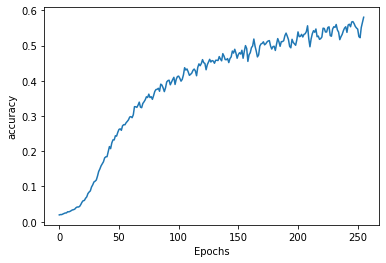

In [57]:
plot_graphs(history, 'accuracy')


In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'val_loss')

In [ ]:
plot_graphs(history, 'val_accuracy')

In [ ]:
def predict(first, second, third, forth, fifth, sixth):
    predict = model.predict([[sortedClassContents.index(first),sortedClassContents.index(second),sortedClassContents.index(third),sortedClassContents.index(forth), sortedClassContents.index(fifth),sortedClassContents.index(sixth)]])
    return sortedClassContents[np.argmax(predict[0])]

In [ ]:
predictResult = predict(0,0,0,1781,1791,626)
print(predictResult)

In [ ]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 100
INPUT_SIZE = MAX_SEQUENCE
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1,4], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "model"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

In [ ]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
print(input_details[0]["index"])
for i in range(TEST_CASES):
  expected = model.predict([[0,0,0,i]])
  interpreter.set_tensor( input_details[0]["index"], np.array([[0,0,0,i]]).astype(np.float32))
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]["index"])

  # Assert if the result of TFLite model is consistent with the TF model.
  np.testing.assert_almost_equal(expected, result)
  print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

  # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
  # the states.
  # Clean up internal states.
  interpreter.reset_all_variables()


In [ ]:
open("converted_model.tflite", "wb").write(tflite_model)

In [ ]:
interpreter.set_tensor( input_details[0]["index"], np.array([[0,0,0,sortedClassContents.index(700)]]).astype(np.float32))
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]["index"])
print(sortedClassContents[np.argmax(result)])